In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from code.util import *
from code.modelhelper import *

# MLP w/ Engineered Features

In [2]:
BATCH_SIZE = 256
N_CLASS = 2
EPOCHS = 300

In [3]:
x = np.load("data/xy/x_feat_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [4]:
x.shape

(60000, 50)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11)

In [8]:
model_input = Input(shape=(x.shape[1], ), name="m1_input")
H = Dense(51, activation="relu", name="m1_dense1")(model_input)
# H = Dropout(0.2)(H)
H = Dense(128, activation="relu", name="m1_dense2")(H)
H = Dropout(0.4, name="m1_dropout")(H)
H = Dense(32, activation="relu", name="m1_dense3")(H)
# H = Dropout(0.2)(H)
model_output = Dense(N_CLASS, activation="softmax", name="m1_output")(H)

model = Model(inputs=model_input, outputs=model_output)
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_input (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
m1_dense1 (Dense)            (None, 51)                2601      
_________________________________________________________________
m1_dense2 (Dense)            (None, 128)               6656      
_________________________________________________________________
m1_dropout (Dropout)         (None, 128)               0         
_________________________________________________________________
m1_dense3 (Dense)            (None, 32)                4128      
_________________________________________________________________
m1_output (Dense)            (None, 2)                 66        
Total params: 13,451
Trainable params: 13,451
Non-trainable params: 0
_________________________________________________________

In [9]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test, verbose=2)

W0823 16:16:43.466861 4673828288 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4558 - accuracy: 0.8162 - val_loss: 0.2794 - val_accuracy: 0.8957
Epoch 2/300
48000/48000 [==============================] - 0s 7us/sample - loss: 0.2719 - accuracy: 0.9036 - val_loss: 0.2305 - val_accuracy: 0.9199
Epoch 3/300
48000/48000 [==============================] - 0s 7us/sample - loss: 0.2400 - accuracy: 0.9147 - val_loss: 0.2156 - val_accuracy: 0.9228
Epoch 4/300
48000/48000 [==============================] - 0s 8us/sample - loss: 0.2293 - accuracy: 0.9191 - val_loss: 0.2112 - val_accuracy: 0.9251
Epoch 5/300
48000/48000 [==============================] - 0s 7us/sample - loss: 0.2263 - accuracy: 0.9188 - val_loss: 0.2116 - val_accuracy: 0.9242
Epoch 6/300
48000/48000 [==============================] - 0s 6us/sample - loss: 0.2218 - accuracy: 0.9208 - val_loss: 0.2121 - val_accuracy: 0.9267
Epoch 7/300
48000/48000 [==============================

In [10]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_model = model.predict(x_test)
y_pred = to_bin(y_pred_model)
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.19259977169334888
Test accuracy: 0.9316667
Test recall: 0.7935113213923622
[[8832  209]
 [ 611 2348]]


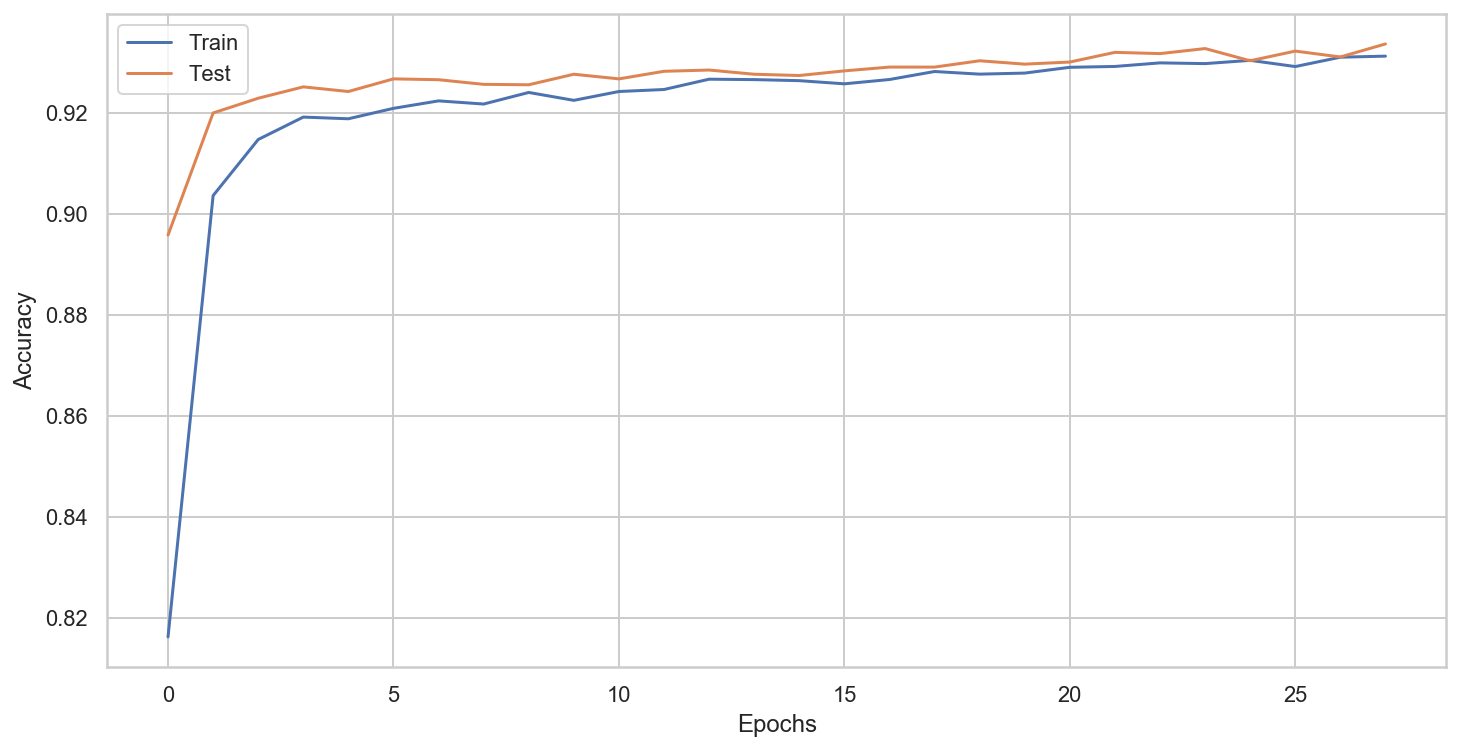

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [12]:
model.save("models/dl/m1.h5")